### An exploration of Perlin Noise and the Smoothstep function

In [1]:
import numpy as np
import matplotlib.pyplot as plt

S1(x) = 1.00 x^1
S2(x) = 3.00 x^2 + -2.00 x^3
S3(x) = 10.00 x^3 + -15.00 x^4 + 6.00 x^5
S4(x) = 35.00 x^4 + -84.00 x^5 + 70.00 x^6 + -20.00 x^7
S5(x) = 126.00 x^5 + -420.00 x^6 + 540.00 x^7 + -315.00 x^8 + 70.00 x^9
S6(x) = 462.00 x^6 + -1980.00 x^7 + 3465.00 x^8 + -3080.00 x^9 + 1386.00 x^10 + -252.00 x^11
S7(x) = 1716.00 x^7 + -9009.00 x^8 + 20020.00 x^9 + -24024.00 x^10 + 16380.00 x^11 + -6006.00 x^12 + 924.00 x^13
S8(x) = 6435.00 x^8 + -40040.00 x^9 + 108108.00 x^10 + -163800.00 x^11 + 150150.00 x^12 + -83160.00 x^13 + 25740.00 x^14 + -3432.00 x^15
S9(x) = 24309.98 x^9 + -175031.83 x^10 + 556919.44 x^11 + -1021018.96 x^12 + 1178098.79 x^13 + -875159.09 x^14 + 408407.57 x^15 + -109394.88 x^16 + 12869.99 x^17


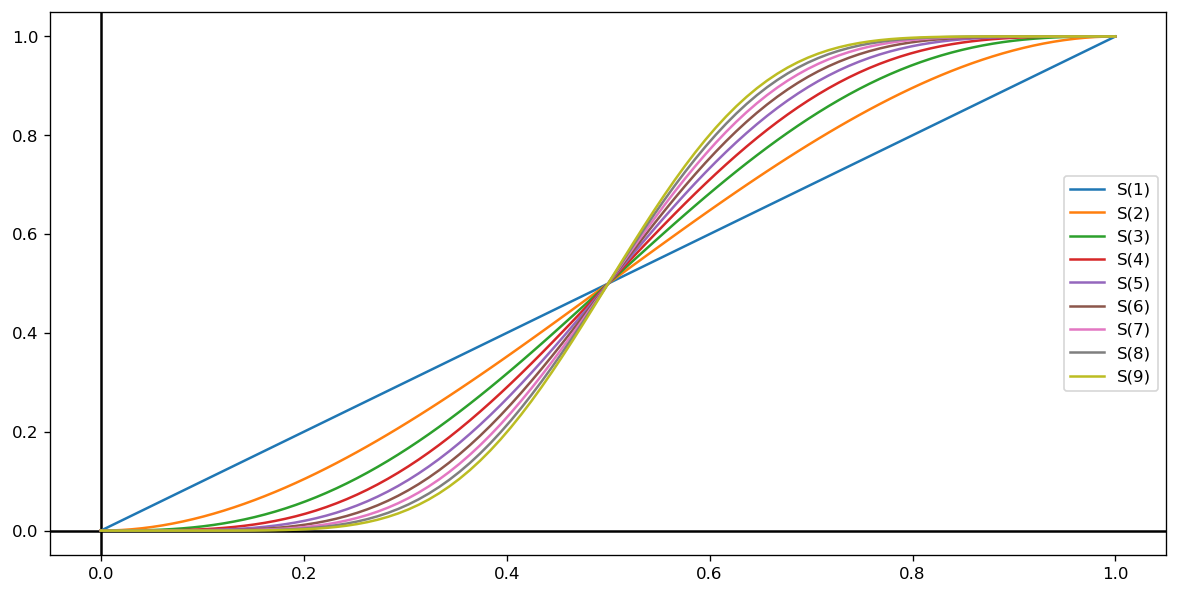

In [39]:
import math


"""
the nth degree smoothstep function has the property that
- it is a polynomial of degree 2n
- it satifies: S(0) = 0, S(1) = 1, and forall i from 1 to n-1, S^i(0) = S^i(1) = 0

this implies that an n-dgree smoothstep function is nth differentiably smooth on its boundaries
"""



class smoothstep:
    """
    The smoothstep function

    Usage:
    ```
    st = smoothstep(degree=3)
    assert st.eval(0) == 0
    assert st.eval(1) == 1
    ```
    """

    def __init__(self, degree: int = 1):
        # generate coefficients
        self.coef = smoothstep.smoothstep_coefficients(degree)
        self.degree = len(self.coef) - 1

    def eval(self, x):
        # this is brilliant!
        # [[c0,      c0,      ...]
        #  [c1 x0^1, c1 x1^1, ...] ...]
        # and axis=0 meanings summing down the column
        # because axis=0 represents summing along the 0th index into the matrix (the row index)

        return np.sum(
            [self.coef[i] * np.power(x, i) for i in range(self.degree + 1)], 
            axis=0
        )

    def __str__(self) -> str:
        out = []
        for i in range(self.degree + 1):
            if abs(self.coef[i]) < 0.001:
                continue

            out.append(
                f"{self.coef[i]:.2f} x^{i}"
            )
        
        return ' + '.join(out)


    @staticmethod
    def smoothstep_coefficients(degree: int):
        """
        Returns the smoothstep polynomial coefficients of degree `degree`

        We solve this by solving the system `Ax=y`
        where `x` is the vector of coefficients, and `A` `y` represent the boundary constraints
        """


        # there are 2n terms
        terms = 2 * degree

        A = []

        # constraints
        # from 0th order to n-1th order
        for d in range(degree):
            # these are the coef multipliers as a result of repeated differentiations
            multipliers = []
            for t in range(terms):

                # the multiplier at index t after d differentiation has the formula
                # if t-d >= 0
                #   c(t, d) = t! / (t-d)!
                # else
                #   c(t, d) = 0
                value = 0
                if t-d >= 0:
                    # compute t!/(t-d)!
                    value = math.factorial(t) / math.factorial(t-d)

                multipliers.append(value)

            # S^d (0)
            # we only use the dth coef for all the others are zero
            Sd0 = [0] * terms
            Sd0[d] = multipliers[d]
            A.append(Sd0)

            # S^d (1)
            # we use all the coefs
            A.append(multipliers)

        # all the RHS are zero except where S(1) =1
        y = [0] * terms
        y[1] = 1

        A = np.array(A)
        y = np.array(y)

        return np.linalg.solve(A, y)





def plot():
    plt.figure(figsize=(12, 6), dpi=120)

    plt.axhline(0, c='black')
    # plt.axhline(1, c='black')
    plt.axvline(0, c='black')

    xs = np.linspace(0, 1, 100)

    for d in range(1, 10):
        st = smoothstep(d)
        ys = st.eval(xs)
        plt.plot(xs, ys, label=f"S({d})")
        
        print(f"S{d}(x) = {st}")

    plt.legend()


In [98]:
import itertools

class perlin_noise:

    def __init__(self, size: int, seed: int = 0):
        self.size = size
        self.seed = seed

        # generate gradient field
        # in a seperate function because it is large
        self.gradients = perlin_noise.create_gradients(size, seed)

    @staticmethod
    def create_gradients(size: int, seed: int):
        """
        Create the randomized gradient field for perlin noise
        """

        np.random.seed(seed)

        # generate angles from [0, 2pi]
        angles = 2 * np.pi * np.random.rand(size, size)
        # create unit gradient field
        gradients = np.stack(
            (np.cos(angles), np.sin(angles)),
            axis=2
            # meaning that at axis 2 (third index)
            # g[x][y][0] = np.cos(angles)[x][y] and g[x][y][1] = np.sin(angles)[x][y]
        )

        return gradients


    def sample(self, x: float, y: float, st: smoothstep):
        # check bounds
        assert 0 <= x <= self.size
        assert 0 <= y <= self.size


        # anchoring top left
        int_x, int_y = math.floor(x), math.floor(y)

        position = np.array([x, y], dtype=np.float64)

        # for all four corners
        # bottom left, bottom right, top left, top right
        dots = []
        for rel_x, rel_y in [[0, 0], [1, 0], [0, 1], [1, 1]]:
            corner = (int_x + rel_x, int_y + rel_y)
            grads = self.gradients[corner]

            disp = np.array(corner, dtype=np.float64) - position # type: ignore
            dot = np.dot(grads, disp)

            dots.append(dot)

        bl, br, tl, tr = dots

        # interpolate against the four gradients
        top = tl + st.eval(x - int_x) * (tr - tl)
        bottom = bl + st.eval(x - int_x) * (br - bl)

        return bottom + st.eval(y - int_y) * (top - bottom)
        

p = perlin_noise(12, 10)

res = 512

xs = np.linspace(0, 10, res)
ys = np.linspace(0, 10, res)

from PIL import Image
img = Image.new('RGB', (res, res))


st = smoothstep(2)
for ix, iy in itertools.product(range(len(xs)), range(len(ys))):
    x, y = xs[ix], ys[iy]
    value = p.sample(x, y, st)
    brightness = math.floor((value + 1) * 256 / 2)
    img.putpixel((ix, iy), (brightness, brightness, brightness))

img.show()
img.save('noise2.png')




# plt.figure(figsize=(12, 12), dpi=100)
# plt.pcolormesh(xs, ys, c)